### Architecture idea (SIMPLE DIAGRAM)

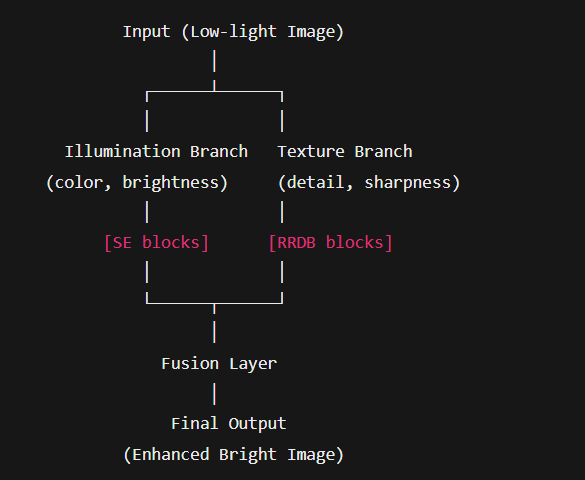

In [1]:
!pip install numpy
!pip install torchmetrics
!pip install piq
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from torchvision.datasets import DatasetFolder
from datetime import datetime
from sklearn.model_selection import train_test_split

In [2]:
# def set_seed(seed=42):
#     """Set all random seeds for reproducibility."""
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)  # if using multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Set the seed (choose any number you like)
# set_seed(42) 

# Run Data

In [3]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_random_invert/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [4]:
target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [5]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [6]:
batch_size=8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [7]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['549.png', '542.png', '579.png', '138.png', '102.png', '95.png', '752.png', '105.png']
High resolution file name: ['549.png', '542.png', '579.png', '138.png', '102.png', '95.png', '752.png', '105.png']


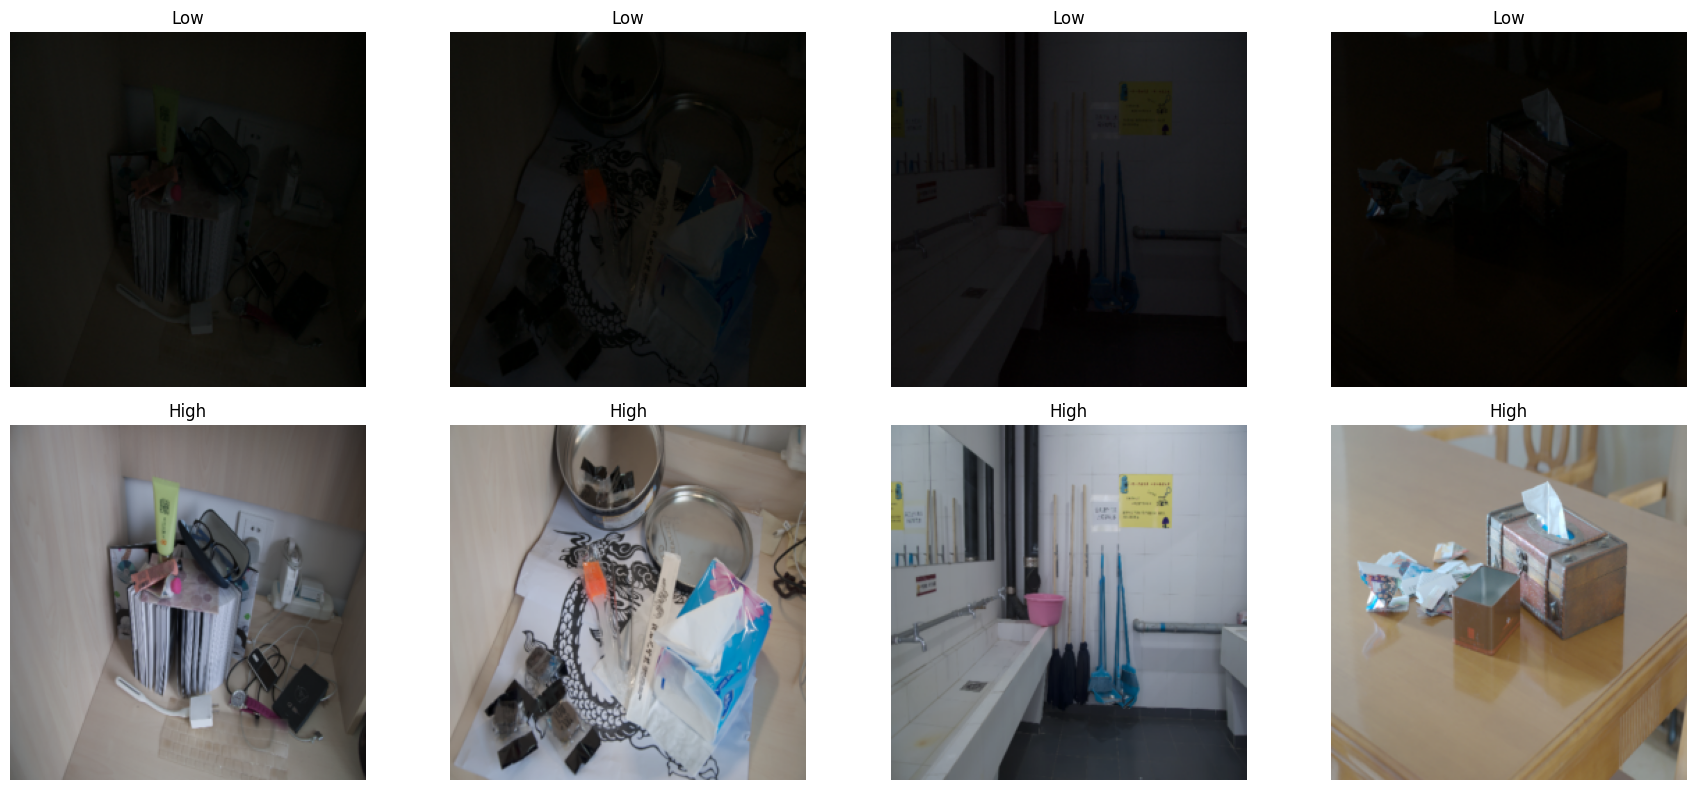

In [8]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

# MODEL ARCHITECTURE

In [9]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [11]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [12]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

# Training preparation:

In [13]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilit

# Training LOOP

In [14]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [15]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS_random_invert"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_lpips = 100
    best_psnr = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

            
        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [16]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:22<00:00,  2.14it/s, D_loss=0.054, G_loss=17.283,
                                                                                


Validation @ Epoch 1:
PSNR: 13.19 dB | SSIM: 0.5072 | LPIPS: 0.6535
🔥 New best model (PSNR: 13.1889 | LPIPS: 0.6535 | SSIM: 0.5072) saved!
🔥 New best model (LPIPS: 0.6535 | SSIM: 0.5072) saved!
🔥 New best model (PSNR: 13.1889 | SSIM: 0.5072) saved!
🔥 New best model (PSNR: 13.1889 | LPIPS: 0.6535) saved!
🔥 New best model (SSIM: 0.5072) saved!
🔥 New best model (PSNR: 13.1889) saved!
🔥 New best model (LPIPS: 0.6535) saved!


Epoch 2/200: 100%|█| 49/49 [00:22<00:00,  2.18it/s, D_loss=0.175, G_loss=14.668,
                                                                                


Validation @ Epoch 2:
PSNR: 14.25 dB | SSIM: 0.5705 | LPIPS: 0.5663
🔥 New best model (PSNR: 14.2490 | LPIPS: 0.5663 | SSIM: 0.5705) saved!
🔥 New best model (LPIPS: 0.5663 | SSIM: 0.5705) saved!
🔥 New best model (PSNR: 14.2490 | SSIM: 0.5705) saved!
🔥 New best model (PSNR: 14.2490 | LPIPS: 0.5663) saved!
🔥 New best model (SSIM: 0.5705) saved!
🔥 New best model (PSNR: 14.2490) saved!
🔥 New best model (LPIPS: 0.5663) saved!


Epoch 3/200: 100%|█| 49/49 [00:22<00:00,  2.14it/s, D_loss=0.071, G_loss=16.660,
                                                                                


Validation @ Epoch 3:
PSNR: 15.19 dB | SSIM: 0.6107 | LPIPS: 0.5072
🔥 New best model (PSNR: 15.1890 | LPIPS: 0.5072 | SSIM: 0.6107) saved!
🔥 New best model (LPIPS: 0.5072 | SSIM: 0.6107) saved!
🔥 New best model (PSNR: 15.1890 | SSIM: 0.6107) saved!
🔥 New best model (PSNR: 15.1890 | LPIPS: 0.5072) saved!
🔥 New best model (SSIM: 0.6107) saved!
🔥 New best model (PSNR: 15.1890) saved!
🔥 New best model (LPIPS: 0.5072) saved!


Epoch 4/200: 100%|█| 49/49 [00:23<00:00,  2.11it/s, D_loss=0.079, G_loss=16.677,
                                                                                


Validation @ Epoch 4:
PSNR: 16.67 dB | SSIM: 0.6442 | LPIPS: 0.4846
🔥 New best model (PSNR: 16.6721 | LPIPS: 0.4846 | SSIM: 0.6442) saved!
🔥 New best model (LPIPS: 0.4846 | SSIM: 0.6442) saved!
🔥 New best model (PSNR: 16.6721 | SSIM: 0.6442) saved!
🔥 New best model (PSNR: 16.6721 | LPIPS: 0.4846) saved!
🔥 New best model (SSIM: 0.6442) saved!
🔥 New best model (PSNR: 16.6721) saved!
🔥 New best model (LPIPS: 0.4846) saved!


Epoch 5/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.480, G_loss=22.071,
                                                                                


Validation @ Epoch 5:
PSNR: 16.12 dB | SSIM: 0.6424 | LPIPS: 0.4740
🔥 New best model (LPIPS: 0.4740) saved!


Epoch 6/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.046, G_loss=14.400,
                                                                                


Validation @ Epoch 6:
PSNR: 16.86 dB | SSIM: 0.6597 | LPIPS: 0.5214
🔥 New best model (PSNR: 16.8560 | SSIM: 0.6597) saved!
🔥 New best model (SSIM: 0.6597) saved!
🔥 New best model (PSNR: 16.8560) saved!


Epoch 7/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.253, G_loss=15.313,
                                                                                


Validation @ Epoch 7:
PSNR: 16.95 dB | SSIM: 0.6627 | LPIPS: 0.4301
🔥 New best model (PSNR: 16.9539 | LPIPS: 0.4301 | SSIM: 0.6627) saved!
🔥 New best model (LPIPS: 0.4301 | SSIM: 0.6627) saved!
🔥 New best model (PSNR: 16.9539 | SSIM: 0.6627) saved!
🔥 New best model (PSNR: 16.9539 | LPIPS: 0.4301) saved!
🔥 New best model (SSIM: 0.6627) saved!
🔥 New best model (PSNR: 16.9539) saved!
🔥 New best model (LPIPS: 0.4301) saved!


Epoch 8/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.110, G_loss=18.588,
                                                                                


Validation @ Epoch 8:
PSNR: 17.16 dB | SSIM: 0.6936 | LPIPS: 0.3966
🔥 New best model (PSNR: 17.1636 | LPIPS: 0.3966 | SSIM: 0.6936) saved!
🔥 New best model (LPIPS: 0.3966 | SSIM: 0.6936) saved!
🔥 New best model (PSNR: 17.1636 | SSIM: 0.6936) saved!
🔥 New best model (PSNR: 17.1636 | LPIPS: 0.3966) saved!
🔥 New best model (SSIM: 0.6936) saved!
🔥 New best model (PSNR: 17.1636) saved!
🔥 New best model (LPIPS: 0.3966) saved!


Epoch 9/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.303, G_loss=15.459,
                                                                                


Validation @ Epoch 9:
PSNR: 16.64 dB | SSIM: 0.5341 | LPIPS: 0.4594


Epoch 10/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.727, G_loss=17.229
                                                                                


Validation @ Epoch 10:
PSNR: 17.22 dB | SSIM: 0.6720 | LPIPS: 0.4464
🔥 New best model (PSNR: 17.2230) saved!


Epoch 11/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.132, G_loss=17.131
                                                                                


Validation @ Epoch 11:
PSNR: 17.37 dB | SSIM: 0.7141 | LPIPS: 0.3654
🔥 New best model (PSNR: 17.3694 | LPIPS: 0.3654 | SSIM: 0.7141) saved!
🔥 New best model (LPIPS: 0.3654 | SSIM: 0.7141) saved!
🔥 New best model (PSNR: 17.3694 | SSIM: 0.7141) saved!
🔥 New best model (PSNR: 17.3694 | LPIPS: 0.3654) saved!
🔥 New best model (SSIM: 0.7141) saved!
🔥 New best model (PSNR: 17.3694) saved!
🔥 New best model (LPIPS: 0.3654) saved!


Epoch 12/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.275, G_loss=13.522
                                                                                


Validation @ Epoch 12:
PSNR: 17.42 dB | SSIM: 0.6726 | LPIPS: 0.3952
🔥 New best model (PSNR: 17.4206) saved!


Epoch 13/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.170, G_loss=16.522
                                                                                


Validation @ Epoch 13:
PSNR: 17.25 dB | SSIM: 0.6816 | LPIPS: 0.4392


Epoch 14/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.257, G_loss=10.279
                                                                                


Validation @ Epoch 14:
PSNR: 17.19 dB | SSIM: 0.7026 | LPIPS: 0.4110


Epoch 15/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.222, G_loss=15.094
                                                                                


Validation @ Epoch 15:
PSNR: 16.93 dB | SSIM: 0.6986 | LPIPS: 0.4485


Epoch 16/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.281, G_loss=11.889
                                                                                


Validation @ Epoch 16:
PSNR: 18.09 dB | SSIM: 0.7710 | LPIPS: 0.3734
🔥 New best model (PSNR: 18.0937 | SSIM: 0.7710) saved!
🔥 New best model (SSIM: 0.7710) saved!
🔥 New best model (PSNR: 18.0937) saved!


Epoch 17/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.198, G_loss=13.817
                                                                                


Validation @ Epoch 17:
PSNR: 17.18 dB | SSIM: 0.7569 | LPIPS: 0.3708


Epoch 18/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.462, G_loss=16.395
                                                                                


Validation @ Epoch 18:
PSNR: 17.25 dB | SSIM: 0.7684 | LPIPS: 0.3450
🔥 New best model (LPIPS: 0.3450) saved!


Epoch 19/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.233, G_loss=14.359
                                                                                


Validation @ Epoch 19:
PSNR: 18.08 dB | SSIM: 0.7620 | LPIPS: 0.3327
🔥 New best model (LPIPS: 0.3327) saved!


Epoch 20/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.181, G_loss=15.530
                                                                                


Validation @ Epoch 20:
PSNR: 16.41 dB | SSIM: 0.7515 | LPIPS: 0.3914


Epoch 21/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.397, G_loss=8.042,
                                                                                


Validation @ Epoch 21:
PSNR: 18.00 dB | SSIM: 0.7743 | LPIPS: 0.3020
🔥 New best model (LPIPS: 0.3020 | SSIM: 0.7743) saved!
🔥 New best model (SSIM: 0.7743) saved!
🔥 New best model (LPIPS: 0.3020) saved!


Epoch 22/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.327, G_loss=17.303
                                                                                


Validation @ Epoch 22:
PSNR: 16.50 dB | SSIM: 0.7732 | LPIPS: 0.4006


Epoch 23/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.155, G_loss=14.006
                                                                                


Validation @ Epoch 23:
PSNR: 16.56 dB | SSIM: 0.7303 | LPIPS: 0.3622


Epoch 24/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.285, G_loss=8.588,
                                                                                


Validation @ Epoch 24:
PSNR: 18.44 dB | SSIM: 0.7831 | LPIPS: 0.3227
🔥 New best model (PSNR: 18.4449 | SSIM: 0.7831) saved!
🔥 New best model (SSIM: 0.7831) saved!
🔥 New best model (PSNR: 18.4449) saved!


Epoch 25/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.352, G_loss=13.701
                                                                                


Validation @ Epoch 25:
PSNR: 18.30 dB | SSIM: 0.7833 | LPIPS: 0.3188
🔥 New best model (SSIM: 0.7833) saved!


Epoch 26/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.336, G_loss=15.842
                                                                                


Validation @ Epoch 26:
PSNR: 18.58 dB | SSIM: 0.7917 | LPIPS: 0.3096
🔥 New best model (PSNR: 18.5778 | SSIM: 0.7917) saved!
🔥 New best model (SSIM: 0.7917) saved!
🔥 New best model (PSNR: 18.5778) saved!


Epoch 27/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.357, G_loss=12.238
                                                                                


Validation @ Epoch 27:
PSNR: 17.76 dB | SSIM: 0.7792 | LPIPS: 0.3933


Epoch 28/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.193, G_loss=12.886
                                                                                


Validation @ Epoch 28:
PSNR: 18.70 dB | SSIM: 0.8106 | LPIPS: 0.3117
🔥 New best model (PSNR: 18.6953 | SSIM: 0.8106) saved!
🔥 New best model (SSIM: 0.8106) saved!
🔥 New best model (PSNR: 18.6953) saved!


Epoch 29/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.606, G_loss=11.158
                                                                                


Validation @ Epoch 29:
PSNR: 18.76 dB | SSIM: 0.8032 | LPIPS: 0.3269
🔥 New best model (PSNR: 18.7588) saved!


Epoch 30/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.265, G_loss=15.373
                                                                                


Validation @ Epoch 30:
PSNR: 17.92 dB | SSIM: 0.7624 | LPIPS: 0.3583


Epoch 31/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.154, G_loss=15.699
                                                                                


Validation @ Epoch 31:
PSNR: 17.51 dB | SSIM: 0.7746 | LPIPS: 0.3143


Epoch 32/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.205, G_loss=10.959
                                                                                


Validation @ Epoch 32:
PSNR: 18.49 dB | SSIM: 0.8162 | LPIPS: 0.2719
🔥 New best model (LPIPS: 0.2719 | SSIM: 0.8162) saved!
🔥 New best model (SSIM: 0.8162) saved!
🔥 New best model (LPIPS: 0.2719) saved!


Epoch 33/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.291, G_loss=14.897
                                                                                


Validation @ Epoch 33:
PSNR: 17.67 dB | SSIM: 0.8048 | LPIPS: 0.2757


Epoch 34/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.423, G_loss=16.778
                                                                                


Validation @ Epoch 34:
PSNR: 18.26 dB | SSIM: 0.8140 | LPIPS: 0.3022


Epoch 35/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.411, G_loss=13.230
                                                                                


Validation @ Epoch 35:
PSNR: 18.56 dB | SSIM: 0.8249 | LPIPS: 0.2738
🔥 New best model (SSIM: 0.8249) saved!


Epoch 36/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.408, G_loss=13.214
                                                                                


Validation @ Epoch 36:
PSNR: 18.79 dB | SSIM: 0.8158 | LPIPS: 0.2902
🔥 New best model (PSNR: 18.7947) saved!


Epoch 37/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.441, G_loss=11.625
                                                                                


Validation @ Epoch 37:
PSNR: 18.72 dB | SSIM: 0.8039 | LPIPS: 0.3135


Epoch 38/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.520, G_loss=10.249
                                                                                


Validation @ Epoch 38:
PSNR: 19.16 dB | SSIM: 0.8104 | LPIPS: 0.2965
🔥 New best model (PSNR: 19.1574) saved!


Epoch 39/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.360, G_loss=9.300,
                                                                                


Validation @ Epoch 39:
PSNR: 18.91 dB | SSIM: 0.8021 | LPIPS: 0.2981


Epoch 40/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.300, G_loss=13.100
                                                                                


Validation @ Epoch 40:
PSNR: 18.75 dB | SSIM: 0.7832 | LPIPS: 0.3015


Epoch 41/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.253, G_loss=12.846
                                                                                


Validation @ Epoch 41:
PSNR: 18.31 dB | SSIM: 0.7865 | LPIPS: 0.3002


Epoch 42/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.272, G_loss=11.055
                                                                                


Validation @ Epoch 42:
PSNR: 19.09 dB | SSIM: 0.8162 | LPIPS: 0.2849


Epoch 43/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.454, G_loss=15.792
                                                                                


Validation @ Epoch 43:
PSNR: 17.23 dB | SSIM: 0.8060 | LPIPS: 0.2867


Epoch 44/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.375, G_loss=9.533,
                                                                                


Validation @ Epoch 44:
PSNR: 18.80 dB | SSIM: 0.7679 | LPIPS: 0.3297


Epoch 45/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.135, G_loss=12.282
                                                                                


Validation @ Epoch 45:
PSNR: 18.12 dB | SSIM: 0.7940 | LPIPS: 0.2799


Epoch 46/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.419, G_loss=12.401
                                                                                


Validation @ Epoch 46:
PSNR: 19.14 dB | SSIM: 0.8127 | LPIPS: 0.2811


Epoch 47/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.269, G_loss=15.123
                                                                                


Validation @ Epoch 47:
PSNR: 18.47 dB | SSIM: 0.7671 | LPIPS: 0.3601


Epoch 48/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.232, G_loss=10.078
                                                                                


Validation @ Epoch 48:
PSNR: 18.90 dB | SSIM: 0.8215 | LPIPS: 0.2714
🔥 New best model (LPIPS: 0.2714) saved!


Epoch 49/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.491, G_loss=12.904
                                                                                


Validation @ Epoch 49:
PSNR: 18.55 dB | SSIM: 0.8022 | LPIPS: 0.3003


Epoch 50/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.685, G_loss=14.859
                                                                                


Validation @ Epoch 50:
PSNR: 18.77 dB | SSIM: 0.8131 | LPIPS: 0.2825


Epoch 51/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.077, G_loss=16.861
                                                                                


Validation @ Epoch 51:
PSNR: 18.38 dB | SSIM: 0.8045 | LPIPS: 0.2882


Epoch 52/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.252, G_loss=10.700
                                                                                


Validation @ Epoch 52:
PSNR: 18.80 dB | SSIM: 0.8165 | LPIPS: 0.2885


Epoch 53/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.108, G_loss=10.586
                                                                                


Validation @ Epoch 53:
PSNR: 18.98 dB | SSIM: 0.7918 | LPIPS: 0.3139


Epoch 54/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.570, G_loss=8.090,
                                                                                


Validation @ Epoch 54:
PSNR: 19.19 dB | SSIM: 0.8122 | LPIPS: 0.2860
🔥 New best model (PSNR: 19.1901) saved!


Epoch 55/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.115, G_loss=14.494
                                                                                


Validation @ Epoch 55:
PSNR: 17.10 dB | SSIM: 0.8079 | LPIPS: 0.2699
🔥 New best model (LPIPS: 0.2699) saved!


Epoch 56/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.201, G_loss=11.097
                                                                                


Validation @ Epoch 56:
PSNR: 18.59 dB | SSIM: 0.8146 | LPIPS: 0.2820


Epoch 57/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.209, G_loss=12.879
                                                                                


Validation @ Epoch 57:
PSNR: 17.90 dB | SSIM: 0.8227 | LPIPS: 0.2565
🔥 New best model (LPIPS: 0.2565) saved!


Epoch 58/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.359, G_loss=13.626
                                                                                


Validation @ Epoch 58:
PSNR: 16.33 dB | SSIM: 0.6726 | LPIPS: 0.3582


Epoch 59/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.043, G_loss=14.466
                                                                                


Validation @ Epoch 59:
PSNR: 19.02 dB | SSIM: 0.8134 | LPIPS: 0.2630


Epoch 60/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.418, G_loss=7.986,
                                                                                


Validation @ Epoch 60:
PSNR: 18.72 dB | SSIM: 0.7848 | LPIPS: 0.2998


Epoch 61/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.359, G_loss=12.302
                                                                                


Validation @ Epoch 61:
PSNR: 18.78 dB | SSIM: 0.7951 | LPIPS: 0.3182


Epoch 62/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.091, G_loss=18.339
                                                                                


Validation @ Epoch 62:
PSNR: 18.55 dB | SSIM: 0.8237 | LPIPS: 0.2609


Epoch 63/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.151, G_loss=13.980
                                                                                


Validation @ Epoch 63:
PSNR: 17.78 dB | SSIM: 0.8122 | LPIPS: 0.2554
🔥 New best model (LPIPS: 0.2554) saved!


Epoch 64/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.216, G_loss=19.475
                                                                                


Validation @ Epoch 64:
PSNR: 18.88 dB | SSIM: 0.8196 | LPIPS: 0.2921


Epoch 65/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.301, G_loss=14.275
                                                                                


Validation @ Epoch 65:
PSNR: 18.74 dB | SSIM: 0.8047 | LPIPS: 0.2794


Epoch 66/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.225, G_loss=12.386
                                                                                


Validation @ Epoch 66:
PSNR: 18.56 dB | SSIM: 0.8173 | LPIPS: 0.2738


Epoch 67/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.379, G_loss=11.107
                                                                                


Validation @ Epoch 67:
PSNR: 19.09 dB | SSIM: 0.8246 | LPIPS: 0.2583


Epoch 68/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.128, G_loss=28.756
                                                                                


Validation @ Epoch 68:
PSNR: 18.85 dB | SSIM: 0.8188 | LPIPS: 0.2567


Epoch 69/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.246, G_loss=17.100
                                                                                


Validation @ Epoch 69:
PSNR: 17.59 dB | SSIM: 0.7727 | LPIPS: 0.3187


Epoch 70/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.213, G_loss=13.765
                                                                                


Validation @ Epoch 70:
PSNR: 18.65 dB | SSIM: 0.8074 | LPIPS: 0.2905


Epoch 71/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.624, G_loss=8.210,
                                                                                


Validation @ Epoch 71:
PSNR: 17.55 dB | SSIM: 0.7860 | LPIPS: 0.2987


Epoch 72/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.587, G_loss=13.028
                                                                                


Validation @ Epoch 72:
PSNR: 18.42 dB | SSIM: 0.8050 | LPIPS: 0.2697


Epoch 73/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.357, G_loss=10.429
                                                                                


Validation @ Epoch 73:
PSNR: 18.95 dB | SSIM: 0.8337 | LPIPS: 0.2500
🔥 New best model (LPIPS: 0.2500 | SSIM: 0.8337) saved!
🔥 New best model (SSIM: 0.8337) saved!
🔥 New best model (LPIPS: 0.2500) saved!


Epoch 74/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.308, G_loss=9.524,
                                                                                


Validation @ Epoch 74:
PSNR: 18.26 dB | SSIM: 0.8158 | LPIPS: 0.2832


Epoch 75/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.661, G_loss=12.264
                                                                                


Validation @ Epoch 75:
PSNR: 18.80 dB | SSIM: 0.8135 | LPIPS: 0.2785


Epoch 76/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.443, G_loss=14.273
                                                                                


Validation @ Epoch 76:
PSNR: 19.11 dB | SSIM: 0.8171 | LPIPS: 0.2827


Epoch 77/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.207, G_loss=13.687
                                                                                


Validation @ Epoch 77:
PSNR: 18.96 dB | SSIM: 0.8201 | LPIPS: 0.2680


Epoch 78/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.209, G_loss=21.320
                                                                                


Validation @ Epoch 78:
PSNR: 19.14 dB | SSIM: 0.8245 | LPIPS: 0.2705


Epoch 79/200: 100%|█| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.485, G_loss=10.441
                                                                                


Validation @ Epoch 79:
PSNR: 17.64 dB | SSIM: 0.7717 | LPIPS: 0.3064


Epoch 80/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.444, G_loss=13.945
                                                                                


Validation @ Epoch 80:
PSNR: 19.13 dB | SSIM: 0.8226 | LPIPS: 0.2810


Epoch 81/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.167, G_loss=9.445,
                                                                                


Validation @ Epoch 81:
PSNR: 18.82 dB | SSIM: 0.8228 | LPIPS: 0.2646


Epoch 82/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.243, G_loss=9.687,
                                                                                


Validation @ Epoch 82:
PSNR: 18.78 dB | SSIM: 0.8311 | LPIPS: 0.2485
🔥 New best model (LPIPS: 0.2485) saved!


Epoch 83/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.463, G_loss=14.191
                                                                                


Validation @ Epoch 83:
PSNR: 18.96 dB | SSIM: 0.8310 | LPIPS: 0.2533


Epoch 84/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.104, G_loss=10.920
                                                                                


Validation @ Epoch 84:
PSNR: 18.83 dB | SSIM: 0.8211 | LPIPS: 0.2646


Epoch 85/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.225, G_loss=12.571
                                                                                


Validation @ Epoch 85:
PSNR: 18.80 dB | SSIM: 0.8232 | LPIPS: 0.2603


Epoch 86/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.258, G_loss=10.914
                                                                                


Validation @ Epoch 86:
PSNR: 18.86 dB | SSIM: 0.8193 | LPIPS: 0.2527


Epoch 87/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.480, G_loss=8.730,
                                                                                


Validation @ Epoch 87:
PSNR: 18.52 dB | SSIM: 0.8166 | LPIPS: 0.2696


Epoch 88/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.257, G_loss=17.067
                                                                                


Validation @ Epoch 88:
PSNR: 19.17 dB | SSIM: 0.8327 | LPIPS: 0.2603


Epoch 89/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.341, G_loss=10.369
                                                                                


Validation @ Epoch 89:
PSNR: 18.67 dB | SSIM: 0.8111 | LPIPS: 0.2698


Epoch 90/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.367, G_loss=12.846
                                                                                


Validation @ Epoch 90:
PSNR: 18.30 dB | SSIM: 0.7976 | LPIPS: 0.2664


Epoch 91/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.850, G_loss=15.586
                                                                                


Validation @ Epoch 91:
PSNR: 17.31 dB | SSIM: 0.7939 | LPIPS: 0.2842


Epoch 92/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.124, G_loss=17.235
                                                                                


Validation @ Epoch 92:
PSNR: 18.76 dB | SSIM: 0.8325 | LPIPS: 0.2367
🔥 New best model (LPIPS: 0.2367) saved!


Epoch 93/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.194, G_loss=14.334
                                                                                


Validation @ Epoch 93:
PSNR: 19.15 dB | SSIM: 0.8264 | LPIPS: 0.2453


Epoch 94/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.120, G_loss=19.154
                                                                                


Validation @ Epoch 94:
PSNR: 18.09 dB | SSIM: 0.8284 | LPIPS: 0.2442


Epoch 95/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.207, G_loss=18.428
                                                                                


Validation @ Epoch 95:
PSNR: 18.55 dB | SSIM: 0.8360 | LPIPS: 0.2534
🔥 New best model (SSIM: 0.8360) saved!


Epoch 96/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.493, G_loss=12.862
                                                                                


Validation @ Epoch 96:
PSNR: 18.67 dB | SSIM: 0.8183 | LPIPS: 0.2717


Epoch 97/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.270, G_loss=14.029
                                                                                


Validation @ Epoch 97:
PSNR: 18.68 dB | SSIM: 0.8214 | LPIPS: 0.2821


Epoch 98/200: 100%|█| 49/49 [00:23<00:00,  2.05it/s, D_loss=0.329, G_loss=14.848
                                                                                


Validation @ Epoch 98:
PSNR: 18.36 dB | SSIM: 0.8226 | LPIPS: 0.2538


Epoch 99/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.326, G_loss=13.374
                                                                                


Validation @ Epoch 99:
PSNR: 18.34 dB | SSIM: 0.8197 | LPIPS: 0.2782


Epoch 100/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.171, G_loss=9.606
                                                                                


Validation @ Epoch 100:
PSNR: 18.58 dB | SSIM: 0.8341 | LPIPS: 0.2484


Epoch 101/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.278, G_loss=9.808
                                                                                


Validation @ Epoch 101:
PSNR: 18.48 dB | SSIM: 0.8245 | LPIPS: 0.2489


Epoch 102/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.377, G_loss=12.24
                                                                                


Validation @ Epoch 102:
PSNR: 18.08 dB | SSIM: 0.8188 | LPIPS: 0.2791


Epoch 103/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.073, G_loss=13.30
                                                                                


Validation @ Epoch 103:
PSNR: 18.45 dB | SSIM: 0.8031 | LPIPS: 0.2845


Epoch 104/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.257, G_loss=14.24
                                                                                


Validation @ Epoch 104:
PSNR: 18.41 dB | SSIM: 0.8268 | LPIPS: 0.2419


Epoch 105/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.290, G_loss=11.81
                                                                                


Validation @ Epoch 105:
PSNR: 18.67 dB | SSIM: 0.8218 | LPIPS: 0.2488


Epoch 106/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.366, G_loss=7.768
                                                                                


Validation @ Epoch 106:
PSNR: 18.88 dB | SSIM: 0.8255 | LPIPS: 0.2439


Epoch 107/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.393, G_loss=14.88
                                                                                


Validation @ Epoch 107:
PSNR: 18.98 dB | SSIM: 0.8348 | LPIPS: 0.2591


Epoch 108/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.089, G_loss=12.03
                                                                                


Validation @ Epoch 108:
PSNR: 18.58 dB | SSIM: 0.8257 | LPIPS: 0.2494


Epoch 109/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.124, G_loss=12.22
                                                                                


Validation @ Epoch 109:
PSNR: 18.72 dB | SSIM: 0.8282 | LPIPS: 0.2464


Epoch 110/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.147, G_loss=18.28
                                                                                


Validation @ Epoch 110:
PSNR: 18.66 dB | SSIM: 0.8255 | LPIPS: 0.2636


Epoch 111/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.232, G_loss=12.89
                                                                                


Validation @ Epoch 111:
PSNR: 18.29 dB | SSIM: 0.8167 | LPIPS: 0.2642


Epoch 112/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.223, G_loss=9.515
                                                                                


Validation @ Epoch 112:
PSNR: 18.51 dB | SSIM: 0.8106 | LPIPS: 0.2714


Epoch 113/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.178, G_loss=11.49
                                                                                


Validation @ Epoch 113:
PSNR: 18.92 dB | SSIM: 0.8330 | LPIPS: 0.2352
🔥 New best model (LPIPS: 0.2352) saved!


Epoch 114/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.726, G_loss=8.133
                                                                                


Validation @ Epoch 114:
PSNR: 18.81 dB | SSIM: 0.8366 | LPIPS: 0.2632
🔥 New best model (SSIM: 0.8366) saved!


Epoch 115/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.197, G_loss=10.76
                                                                                


Validation @ Epoch 115:
PSNR: 18.30 dB | SSIM: 0.8245 | LPIPS: 0.2403


Epoch 116/200: 100%|█| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.221, G_loss=10.86
                                                                                


Validation @ Epoch 116:
PSNR: 18.46 dB | SSIM: 0.8198 | LPIPS: 0.2568


Epoch 117/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.288, G_loss=11.63
                                                                                


Validation @ Epoch 117:
PSNR: 18.75 dB | SSIM: 0.8302 | LPIPS: 0.2415


Epoch 118/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.305, G_loss=13.19
                                                                                


Validation @ Epoch 118:
PSNR: 18.93 dB | SSIM: 0.8330 | LPIPS: 0.2516


Epoch 119/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.172, G_loss=11.70
                                                                                


Validation @ Epoch 119:
PSNR: 18.97 dB | SSIM: 0.8369 | LPIPS: 0.2373
🔥 New best model (SSIM: 0.8369) saved!


Epoch 120/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.256, G_loss=14.48
                                                                                


Validation @ Epoch 120:
PSNR: 18.58 dB | SSIM: 0.8226 | LPIPS: 0.2673


Epoch 121/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.080, G_loss=13.06
                                                                                


Validation @ Epoch 121:
PSNR: 18.95 dB | SSIM: 0.8273 | LPIPS: 0.2577


Epoch 122/200: 100%|█| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.268, G_loss=12.36
                                                                                


Validation @ Epoch 122:
PSNR: 18.75 dB | SSIM: 0.8187 | LPIPS: 0.2718


Epoch 123/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.114, G_loss=12.37
                                                                                


Validation @ Epoch 123:
PSNR: 18.71 dB | SSIM: 0.8223 | LPIPS: 0.2402


Epoch 124/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.184, G_loss=12.03
                                                                                


Validation @ Epoch 124:
PSNR: 18.37 dB | SSIM: 0.8249 | LPIPS: 0.2612


Epoch 125/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.313, G_loss=11.02
                                                                                


Validation @ Epoch 125:
PSNR: 18.68 dB | SSIM: 0.8258 | LPIPS: 0.2469


Epoch 126/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.344, G_loss=12.23
                                                                                


Validation @ Epoch 126:
PSNR: 18.81 dB | SSIM: 0.8202 | LPIPS: 0.2522


Epoch 127/200: 100%|█| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.088, G_loss=10.96
                                                                                


Validation @ Epoch 127:
PSNR: 18.69 dB | SSIM: 0.8176 | LPIPS: 0.2628


Epoch 128/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.240, G_loss=14.30
                                                                                


Validation @ Epoch 128:
PSNR: 18.68 dB | SSIM: 0.8042 | LPIPS: 0.3120


Epoch 129/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.076, G_loss=8.875
                                                                                


Validation @ Epoch 129:
PSNR: 18.39 dB | SSIM: 0.8338 | LPIPS: 0.2380


Epoch 130/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.113, G_loss=10.69
                                                                                


Validation @ Epoch 130:
PSNR: 18.97 dB | SSIM: 0.8279 | LPIPS: 0.2451


Epoch 131/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.126, G_loss=14.93
                                                                                


Validation @ Epoch 131:
PSNR: 18.27 dB | SSIM: 0.7936 | LPIPS: 0.3020


Epoch 132/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.302, G_loss=12.66
                                                                                


Validation @ Epoch 132:
PSNR: 18.81 dB | SSIM: 0.8292 | LPIPS: 0.2527


Epoch 133/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.101, G_loss=13.13
                                                                                


Validation @ Epoch 133:
PSNR: 18.26 dB | SSIM: 0.8194 | LPIPS: 0.2499


Epoch 134/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.425, G_loss=11.70
                                                                                


Validation @ Epoch 134:
PSNR: 18.44 dB | SSIM: 0.8168 | LPIPS: 0.2599


Epoch 135/200: 100%|█| 49/49 [00:23<00:00,  2.05it/s, D_loss=0.578, G_loss=9.631
                                                                                


Validation @ Epoch 135:
PSNR: 16.85 dB | SSIM: 0.7931 | LPIPS: 0.2582


Epoch 136/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.136, G_loss=9.193
                                                                                


Validation @ Epoch 136:
PSNR: 18.94 dB | SSIM: 0.8342 | LPIPS: 0.2403


Epoch 137/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.121, G_loss=12.24
                                                                                


Validation @ Epoch 137:
PSNR: 18.91 dB | SSIM: 0.8274 | LPIPS: 0.2469


Epoch 138/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.143, G_loss=8.651
                                                                                


Validation @ Epoch 138:
PSNR: 18.97 dB | SSIM: 0.8356 | LPIPS: 0.2303
🔥 New best model (LPIPS: 0.2303) saved!


Epoch 139/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.051, G_loss=10.64
                                                                                


Validation @ Epoch 139:
PSNR: 18.86 dB | SSIM: 0.8203 | LPIPS: 0.2549


Epoch 140/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.053, G_loss=10.43
                                                                                


Validation @ Epoch 140:
PSNR: 18.12 dB | SSIM: 0.8171 | LPIPS: 0.2618


Epoch 141/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.136, G_loss=13.71
                                                                                


Validation @ Epoch 141:
PSNR: 18.77 dB | SSIM: 0.8274 | LPIPS: 0.2450


Epoch 142/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.105, G_loss=11.57
                                                                                


Validation @ Epoch 142:
PSNR: 18.46 dB | SSIM: 0.8099 | LPIPS: 0.2481


Epoch 143/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.284, G_loss=16.38
                                                                                


Validation @ Epoch 143:
PSNR: 18.87 dB | SSIM: 0.8310 | LPIPS: 0.2379


Epoch 144/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.246, G_loss=16.68
                                                                                


Validation @ Epoch 144:
PSNR: 19.09 dB | SSIM: 0.8103 | LPIPS: 0.2760


Epoch 145/200: 100%|█| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.348, G_loss=16.47
                                                                                


Validation @ Epoch 145:
PSNR: 19.12 dB | SSIM: 0.8236 | LPIPS: 0.2650


Epoch 146/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.090, G_loss=10.43
                                                                                


Validation @ Epoch 146:
PSNR: 18.50 dB | SSIM: 0.8285 | LPIPS: 0.2392


Epoch 147/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.085, G_loss=12.40
                                                                                


Validation @ Epoch 147:
PSNR: 18.85 dB | SSIM: 0.8281 | LPIPS: 0.2407


Epoch 148/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.160, G_loss=9.507
                                                                                


Validation @ Epoch 148:
PSNR: 19.07 dB | SSIM: 0.8257 | LPIPS: 0.2456


Epoch 149/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.253, G_loss=12.77
                                                                                


Validation @ Epoch 149:
PSNR: 18.83 dB | SSIM: 0.8277 | LPIPS: 0.2652


Epoch 150/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.120, G_loss=11.99
                                                                                


Validation @ Epoch 150:
PSNR: 18.54 dB | SSIM: 0.8282 | LPIPS: 0.2381


Epoch 151/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.106, G_loss=11.58
                                                                                


Validation @ Epoch 151:
PSNR: 18.51 dB | SSIM: 0.8314 | LPIPS: 0.2292
🔥 New best model (LPIPS: 0.2292) saved!


Epoch 152/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.150, G_loss=10.12
                                                                                


Validation @ Epoch 152:
PSNR: 19.00 dB | SSIM: 0.8241 | LPIPS: 0.2620


Epoch 153/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.085, G_loss=10.16
                                                                                


Validation @ Epoch 153:
PSNR: 18.72 dB | SSIM: 0.8252 | LPIPS: 0.2502


Epoch 154/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.789, G_loss=10.13
                                                                                


Validation @ Epoch 154:
PSNR: 18.24 dB | SSIM: 0.7769 | LPIPS: 0.3077


Epoch 155/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.171, G_loss=8.744
                                                                                


Validation @ Epoch 155:
PSNR: 18.47 dB | SSIM: 0.8283 | LPIPS: 0.2374


Epoch 156/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.208, G_loss=10.60
                                                                                


Validation @ Epoch 156:
PSNR: 19.40 dB | SSIM: 0.8397 | LPIPS: 0.2266
🔥 New best model (PSNR: 19.4014 | LPIPS: 0.2266 | SSIM: 0.8397) saved!
🔥 New best model (LPIPS: 0.2266 | SSIM: 0.8397) saved!
🔥 New best model (PSNR: 19.4014 | SSIM: 0.8397) saved!
🔥 New best model (PSNR: 19.4014 | LPIPS: 0.2266) saved!
🔥 New best model (SSIM: 0.8397) saved!
🔥 New best model (PSNR: 19.4014) saved!
🔥 New best model (LPIPS: 0.2266) saved!


Epoch 157/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.062, G_loss=17.06
                                                                                


Validation @ Epoch 157:
PSNR: 19.13 dB | SSIM: 0.8387 | LPIPS: 0.2278


Epoch 158/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.390, G_loss=14.00
                                                                                


Validation @ Epoch 158:
PSNR: 18.81 dB | SSIM: 0.8311 | LPIPS: 0.2388


Epoch 159/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.124, G_loss=9.982
                                                                                


Validation @ Epoch 159:
PSNR: 19.33 dB | SSIM: 0.8357 | LPIPS: 0.2406


Epoch 160/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.230, G_loss=13.95
                                                                                


Validation @ Epoch 160:
PSNR: 18.74 dB | SSIM: 0.8224 | LPIPS: 0.2471


Epoch 161/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.276, G_loss=16.53
                                                                                


Validation @ Epoch 161:
PSNR: 17.98 dB | SSIM: 0.8246 | LPIPS: 0.2308


Epoch 162/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.240, G_loss=16.48
                                                                                


Validation @ Epoch 162:
PSNR: 18.55 dB | SSIM: 0.8170 | LPIPS: 0.2543


Epoch 163/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.193, G_loss=10.14
                                                                                


Validation @ Epoch 163:
PSNR: 18.88 dB | SSIM: 0.8246 | LPIPS: 0.2399


Epoch 164/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.063, G_loss=12.22
                                                                                


Validation @ Epoch 164:
PSNR: 18.85 dB | SSIM: 0.8302 | LPIPS: 0.2395


Epoch 165/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.176, G_loss=7.618
                                                                                


Validation @ Epoch 165:
PSNR: 19.29 dB | SSIM: 0.8310 | LPIPS: 0.2400


Epoch 166/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.311, G_loss=13.64
                                                                                


Validation @ Epoch 166:
PSNR: 18.75 dB | SSIM: 0.8357 | LPIPS: 0.2352


Epoch 167/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.222, G_loss=15.47
                                                                                


Validation @ Epoch 167:
PSNR: 18.57 dB | SSIM: 0.8247 | LPIPS: 0.2419


Epoch 168/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.223, G_loss=11.05
                                                                                


Validation @ Epoch 168:
PSNR: 18.86 dB | SSIM: 0.8288 | LPIPS: 0.2417


Epoch 169/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.321, G_loss=10.28
                                                                                


Validation @ Epoch 169:
PSNR: 18.89 dB | SSIM: 0.8176 | LPIPS: 0.2493


Epoch 170/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.090, G_loss=10.25
                                                                                


Validation @ Epoch 170:
PSNR: 19.06 dB | SSIM: 0.8253 | LPIPS: 0.2498


Epoch 171/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.175, G_loss=14.07
                                                                                


Validation @ Epoch 171:
PSNR: 19.42 dB | SSIM: 0.8247 | LPIPS: 0.2517
🔥 New best model (PSNR: 19.4230) saved!


Epoch 172/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.157, G_loss=16.13
                                                                                


Validation @ Epoch 172:
PSNR: 19.03 dB | SSIM: 0.8428 | LPIPS: 0.2190
🔥 New best model (LPIPS: 0.2190 | SSIM: 0.8428) saved!
🔥 New best model (SSIM: 0.8428) saved!
🔥 New best model (LPIPS: 0.2190) saved!


Epoch 173/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.142, G_loss=10.11
                                                                                


Validation @ Epoch 173:
PSNR: 19.03 dB | SSIM: 0.8276 | LPIPS: 0.2440


Epoch 174/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.072, G_loss=14.43
                                                                                


Validation @ Epoch 174:
PSNR: 19.43 dB | SSIM: 0.8361 | LPIPS: 0.2291
🔥 New best model (PSNR: 19.4282) saved!


Epoch 175/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.156, G_loss=9.639
                                                                                


Validation @ Epoch 175:
PSNR: 19.24 dB | SSIM: 0.8361 | LPIPS: 0.2345


Epoch 176/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.050, G_loss=10.96
                                                                                


Validation @ Epoch 176:
PSNR: 19.23 dB | SSIM: 0.8301 | LPIPS: 0.2496


Epoch 177/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.059, G_loss=12.38
                                                                                


Validation @ Epoch 177:
PSNR: 19.74 dB | SSIM: 0.8404 | LPIPS: 0.2407
🔥 New best model (PSNR: 19.7431) saved!


Epoch 178/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.067, G_loss=15.31
                                                                                


Validation @ Epoch 178:
PSNR: 19.28 dB | SSIM: 0.8243 | LPIPS: 0.2533


Epoch 179/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.432, G_loss=12.84
                                                                                


Validation @ Epoch 179:
PSNR: 18.92 dB | SSIM: 0.8225 | LPIPS: 0.2438


Epoch 180/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.124, G_loss=11.50
                                                                                


Validation @ Epoch 180:
PSNR: 18.62 dB | SSIM: 0.8166 | LPIPS: 0.2629


Epoch 181/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.198, G_loss=15.24
                                                                                


Validation @ Epoch 181:
PSNR: 18.67 dB | SSIM: 0.8247 | LPIPS: 0.2543


Epoch 182/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.271, G_loss=16.19
                                                                                


Validation @ Epoch 182:
PSNR: 18.60 dB | SSIM: 0.8323 | LPIPS: 0.2313


Epoch 183/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.175, G_loss=12.24
                                                                                


Validation @ Epoch 183:
PSNR: 19.72 dB | SSIM: 0.8470 | LPIPS: 0.2238
🔥 New best model (SSIM: 0.8470) saved!


Epoch 184/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.135, G_loss=10.99
                                                                                


Validation @ Epoch 184:
PSNR: 18.68 dB | SSIM: 0.8113 | LPIPS: 0.2514


Epoch 185/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.479, G_loss=6.832
                                                                                


Validation @ Epoch 185:
PSNR: 19.46 dB | SSIM: 0.8395 | LPIPS: 0.2261


Epoch 186/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.495, G_loss=12.90
                                                                                


Validation @ Epoch 186:
PSNR: 19.67 dB | SSIM: 0.8332 | LPIPS: 0.2481


Epoch 187/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.287, G_loss=14.35
                                                                                


Validation @ Epoch 187:
PSNR: 19.33 dB | SSIM: 0.8366 | LPIPS: 0.2329


Epoch 188/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.061, G_loss=12.49
                                                                                


Validation @ Epoch 188:
PSNR: 18.61 dB | SSIM: 0.8156 | LPIPS: 0.2511


Epoch 189/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.301, G_loss=9.850
                                                                                


Validation @ Epoch 189:
PSNR: 18.80 dB | SSIM: 0.8357 | LPIPS: 0.2301


Epoch 190/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.187, G_loss=11.86
                                                                                


Validation @ Epoch 190:
PSNR: 18.91 dB | SSIM: 0.8324 | LPIPS: 0.2299


Epoch 191/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.179, G_loss=10.04
                                                                                


Validation @ Epoch 191:
PSNR: 19.12 dB | SSIM: 0.8380 | LPIPS: 0.2326


Epoch 192/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.085, G_loss=13.51
                                                                                


Validation @ Epoch 192:
PSNR: 18.95 dB | SSIM: 0.8402 | LPIPS: 0.2247


Epoch 193/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.029, G_loss=12.61
                                                                                


Validation @ Epoch 193:
PSNR: 19.25 dB | SSIM: 0.8364 | LPIPS: 0.2391


Epoch 194/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.122, G_loss=8.389
                                                                                


Validation @ Epoch 194:
PSNR: 19.62 dB | SSIM: 0.8359 | LPIPS: 0.2354


Epoch 195/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.237, G_loss=11.98
                                                                                


Validation @ Epoch 195:
PSNR: 19.50 dB | SSIM: 0.8258 | LPIPS: 0.2492


Epoch 196/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.070, G_loss=12.22
                                                                                


Validation @ Epoch 196:
PSNR: 19.10 dB | SSIM: 0.8287 | LPIPS: 0.2355


Epoch 197/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.066, G_loss=10.72
                                                                                


Validation @ Epoch 197:
PSNR: 18.88 dB | SSIM: 0.8265 | LPIPS: 0.2422


Epoch 198/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.092, G_loss=10.64
                                                                                


Validation @ Epoch 198:
PSNR: 18.91 dB | SSIM: 0.8259 | LPIPS: 0.2401


Epoch 199/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.186, G_loss=11.35
                                                                                


Validation @ Epoch 199:
PSNR: 19.46 dB | SSIM: 0.8350 | LPIPS: 0.2374


Epoch 200/200: 100%|█| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.064, G_loss=13.50
                                                                                


Validation @ Epoch 200:
PSNR: 19.11 dB | SSIM: 0.8319 | LPIPS: 0.2331


In [ ]:
# if val_metrics['ssim'] > best_ssim:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
#     print(f"🔥 New best model (SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")
    
#     if val_metrics['psnr'] > best_psnr and val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

#     best_psnr = val_metrics['psnr']
#     best_ssim = val_metrics['ssim']
#     best_lpips = val_metrics['lpips']
    
# elif val_metrics['psnr'] > best_psnr:
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
#     print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")
    
#     if val_metrics['lpips'] < best_lpips:
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#         print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f}) saved!")
#         torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
#         print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
    
#     best_psnr = val_metrics['psnr']
#     best_lpips = val_metrics['lpips']

# elif val_metrics['lpips'] < best_lpips:
#     best_lpips = val_metrics['lpips']
#     torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
#     print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")   


### Testing Code

In [17]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [18]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [19]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.76it/s]


{'psnr': tensor(20.8442, device='cuda:7'),
 'ssim': tensor(0.8194, device='cuda:7'),
 'lpips': tensor(0.2301, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_10.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_11.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples/sample_12.png',
  '

In [20]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.86it/s]


{'psnr': tensor(20.8442, device='cuda:7'),
 'ssim': tensor(0.8194, device='cuda:7'),
 'lpips': tensor(0.2301, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_ra

In [21]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.82it/s]


{'psnr': tensor(20.8442, device='cuda:7'),
 'ssim': tensor(0.8194, device='cuda:7'),
 'lpips': tensor(0.2301, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_SE_CHE

In [22]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.76it/s]


{'psnr': tensor(20.7480, device='cuda:7'),
 'ssim': tensor(0.8209, device='cuda:7'),
 'lpips': tensor(0.2149, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_SE_CHE

In [23]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.71it/s]


{'psnr': tensor(20.3905, device='cuda:7'),
 'ssim': tensor(0.8172, device='cuda:7'),
 'lpips': tensor(0.2469, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_10.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_PSNR/sample_11.png',
  'RRDB_S

In [24]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.76it/s]


{'psnr': tensor(20.6021, device='cuda:7'),
 'ssim': tensor(0.8220, device='cuda:7'),
 'lpips': tensor(0.2181, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_10.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_SSIM/sample_11.png',
  'RRDB_S

In [25]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.77it/s]


{'psnr': tensor(20.7480, device='cuda:7'),
 'ssim': tensor(0.8209, device='cuda:7'),
 'lpips': tensor(0.2149, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_10.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_11.png

In [26]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_SE_CHECKPOINTS_random_invert/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.77it/s]


{'psnr': tensor(21.5236, device='cuda:7'),
 'ssim': tensor(0.8262, device='cuda:7'),
 'lpips': tensor(0.2268, device='cuda:7'),
 'samples': ['RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_00.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_01.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_02.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_03.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_04.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_05.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_06.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_07.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_08.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_09.png',
  'RRDB_SE_CHECKPOINTS_random_invert/test_samples_epoch200/sample_10.png',
  'RRDB_SE_CHECKPOINTS_random_invert

In [27]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_SE_CHECKPOINTS_random_invert"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

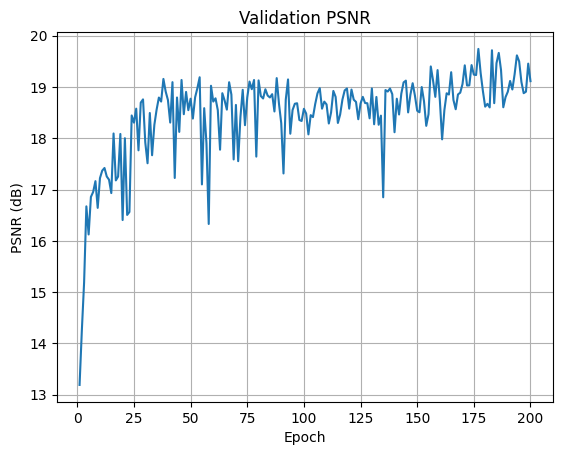

In [28]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_random_invert/validation_psnr.png', dpi=300, bbox_inches='tight')

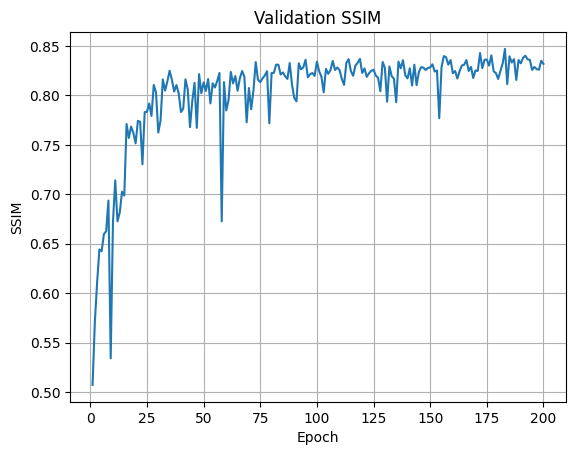

In [29]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_random_invert/validation_ssim.png', dpi=300, bbox_inches='tight')

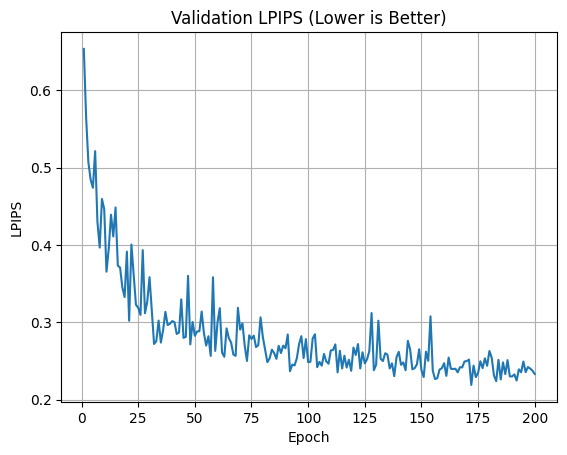

In [30]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_SE_CHECKPOINTS_random_invert/validation_lpips.png', dpi=300, bbox_inches='tight')

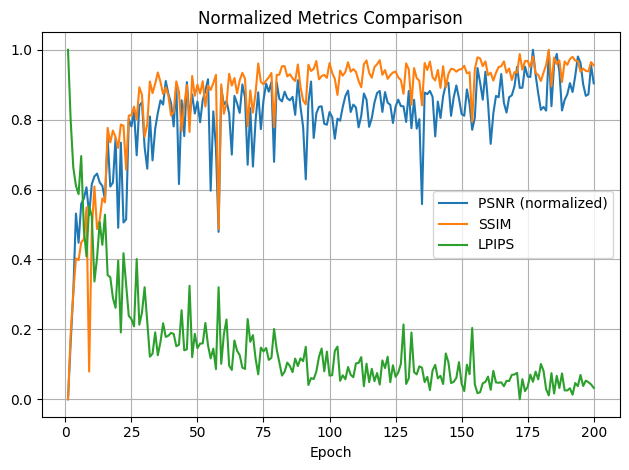

In [31]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_SE_CHECKPOINTS_random_invert/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [32]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_model.pth", map_location=device)
    # generator.load_state_dict(state_dict['generator'], strict=False)
    generator.load_state_dict(state_dict) # use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



In [34]:
def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model (with flexible state_dict handling)
    generator = Generator().to(device)
    state_dict = torch.load("RRDB_SE_CHECKPOINTS_random_invert/best_model.pth", map_location=device)
    if isinstance(state_dict, dict) and 'generator' in state_dict:
        generator.load_state_dict(state_dict['generator'], strict=False)
    else:
        generator.load_state_dict(state_dict, strict=False)

    # Handle new FileUpload value format (tuple of dictionaries)
    if not upload_widget.value:
        return
    
    # Get first uploaded file (even if multiple=False)
    uploaded_file = upload_widget.value[0]  # Gets first tuple element
    
    # Process the image
    image_bytes = uploaded_file['content']
    pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    
    # Transform and process
    input_tensor = transform(pil_image).unsqueeze(0).to(device)
    
    generator.eval()
    with torch.no_grad():
        enhanced_tensor = generator(input_tensor)
    
    enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
    enhanced_image = transforms.ToPILImage()(enhanced_tensor)
    
    # Display results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(pil_image)
    plt.title("Original Low-Light")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(enhanced_image)
    plt.title("Enhanced High-Light")
    plt.axis("off")
    
    plt.show()

In [35]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [36]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [37]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [38]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

In [39]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')